In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from google.colab import files

In [ ]:
# load the data
data = pd.read_csv("solar.csv")
data.head()

In [ ]:
# extract year, month, day, time
timestamp = data['timestamp']
year = []
month = []
day = []
time = []
hour = []
minute = []

for dt in timestamp:
  x = dt.split()
  time.append(x[1])
  z = x[1].split(':')
  hour.append(int(z[0]))
  minute.append(int(z[1]))
  y = x[0].split('.')
  day.append(int(y[0]))
  month.append(int(y[1]))
  year.append(int(y[2]))

data['year'] = year
data['month'] = month
data['day'] = day
data['time'] = time
data['hour'] = hour
data['minute'] = minute
data.head()

,timestamp,solar_power,Unnamed: 2,year,month,day,time,hour,minute
123,12.10.2019 12:07:34,121,,2019,10,12,12:07:34,12,7
122,12.10.2019 13:07:34,51,,2019,10,12,13:07:34,13,7
121,12.10.2019 14:07:34,140,,2019,10,12,14:07:34,14,7
120,12.10.2019 15:07:34,119,,2019,10,12,15:07:34,15,7
119,12.10.2019 16:07:34,40,,2019,10,12,16:07:34,16,7


In [ ]:
# sorting values
data.sort_values(by=['year','month','day','hour'], inplace=True)
print(data)
data.to_csv("solar_clean.csv")


               timestamp  solar_power Unnamed: 2  ...      time  hour  minute
123  12.10.2019 12:07:34          121             ...  12:07:34    12       7
122  12.10.2019 13:07:34           51             ...  13:07:34    13       7
121  12.10.2019 14:07:34          140             ...  14:07:34    14       7
120  12.10.2019 15:07:34          119             ...  15:07:34    15       7
119  12.10.2019 16:07:34           40             ...  16:07:34    16       7
..                   ...          ...        ...  ...       ...   ...     ...
632  27.10.2021 11:04:54        84440        NaN  ...  11:04:54    11       4
631  27.10.2021 12:04:53        73910        NaN  ...  12:04:53    12       4
630  27.10.2021 13:04:54        59370        NaN  ...  13:04:54    13       4
629  27.10.2021 14:04:53        55130        NaN  ...  14:04:53    14       4
628  27.10.2021 15:04:54        49240        NaN  ...  15:04:54    15       4

[1141 rows x 9 columns]


In [ ]:
# Predictor 1: future 24-hr value = previous 24-hr value 
year = data['year'].to_numpy()
month = data['month'].to_numpy()
day = data['day'].to_numpy()
hour = data['hour'].to_numpy()
minute = data['minute'].to_numpy()
power = data['solar_power'].to_numpy()

predicted_power = []
for i in range(24):
  predicted_power.append(-999)

#for i in range(23, len(power), 24):
#  for j in range(24):
#    predicted_power.append(int(power[i+j-24]))

for i in range(24, len(power)):
  #print(year[i], year[i-24], day[i], day[i-24], hour[i], hour[i-24])
  if((year[i] == year[i-24]) and (day[i] == (day[i-24]+1)) and (hour[i] == hour[i-24])):
    predicted_power.append(power[i-24])
  elif((year[i] == year[i-24]) and (month[i] == (month[i-24]+1)) \
       and (day[i] != (day[i-24]+1)) and (hour[i] == hour[i-24])):
        predicted_power.append(power[i-24])
  else:
    predicted_power.append(-999)
  
#for i in range(len(power)):
#  print(year[i], month[i], day[i], hour[i], power[i], predicted_power[i])
  #pass

# save predictions to CSV
df = pd.DataFrame({"year" : year, "month" : month, "day": day, "hour": hour, \
                   "solar_power":predicted_power})
df.to_csv("predictions1.csv", index=False)

# calculate RMS
sum = 0
count = 0
for i in range(700, len(predicted_power)):
  if predicted_power[i] >= 0:
    sum = sum + pow(power[i] - predicted_power[i], 2)
    count = count + 1

rms_err = math.sqrt(sum/count)
print(rms_err/1000)
# result: predictor 1 has 13.6467W RMS error (whole dataset)

11.540783838629737


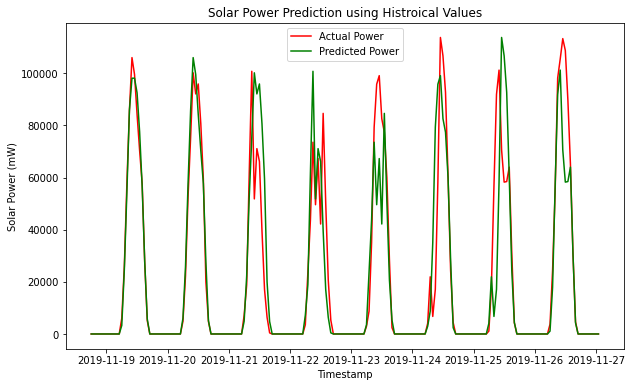

In [ ]:
# plotting actual and predicted values
X = []
for i in range(len(power)):
  X.append(datetime.datetime(year[i], month[i], day[i], hour[i], 0, 0))

plt.figure(figsize=(10, 6))
plt.plot(X[300:500], power[300:500], color='r', label='Actual Power')
plt.plot(X[300:500], predicted_power[300:500], color='g', label='Predicted Power')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Timestamp")
plt.ylabel("Solar Power (mW)")
plt.title("Solar Power Prediction using Histroical Values")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# Download
#plt.savefig('test.pdf')
#files.download('test.pdf')
  
# To load the display window
plt.show()

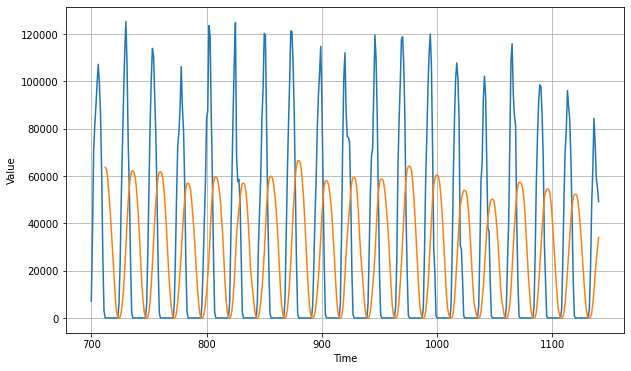

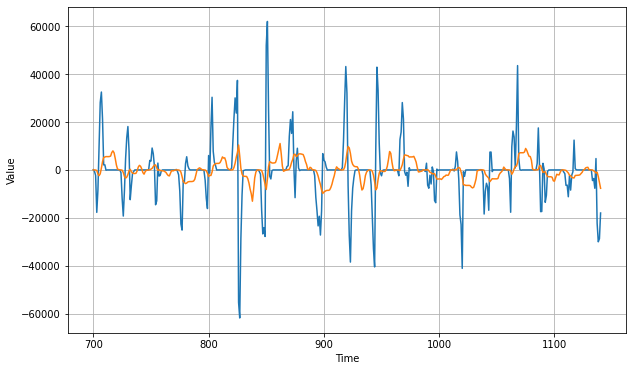

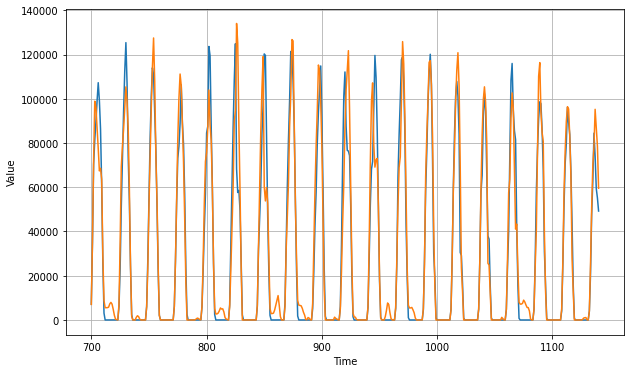

In [ ]:
# Predictor 2: 24-hr moving average 
year = data['year'].to_numpy()
month = data['month'].to_numpy()
day = data['day'].to_numpy()
hour = data['hour'].to_numpy()
minute = data['minute'].to_numpy()
power = data['solar_power'].to_numpy()

def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

split_time = 700    # SQU mission 2
window = 12
time_valid = np.arange(0, len(power), 1)

# Plot the moving average predictor
moving_avg = moving_average_forecast(power, window)
plt.figure(figsize=(10, 6))
plot_series(time_valid[split_time:], power[split_time:])
plot_series(time_valid[split_time+window:], moving_avg[split_time:])  

# Step 1: Take seasonaliy difference
diff_series = power[24:] - power[:-24]

# Step 2: take the moving avg on seasonality difference
diff_moving_avg = moving_average_forecast(diff_series, window)[split_time - 24 - window:]

plt.figure(figsize=(10, 6))
plot_series(time_valid[split_time:], diff_series[split_time - 24:])
plot_series(time_valid[split_time:], diff_moving_avg)
plt.show()

# Step 3: add the past value with current seasonality difference avg
diff_moving_avg_plus_past = power[split_time - 24:-24] + diff_moving_avg
for i in range(len(diff_moving_avg_plus_past)):
  if diff_moving_avg_plus_past[i] < 0:
    diff_moving_avg_plus_past[i] = 0
  #if hour[split_time+i] >= 18 or hour[split_time+i] <= 7:
    #diff_moving_avg_plus_past[i] = 0

plt.figure(figsize=(10, 6))
plot_series(time_valid[split_time:], power[split_time:])
plot_series(time_valid[split_time:], diff_moving_avg_plus_past)
plt.show()

# save predictions to CSV
df = pd.DataFrame({"year" : year[700:], "month" : month[700:], "day": day[700:], "hour": hour[700:], \
                   "solar_power":diff_moving_avg_plus_past})
df.to_csv("predictions2.csv", index=False)

In [ ]:
# calculate RMS
sum = 0
count = 0
for i in range(len(diff_moving_avg_plus_past)):
    sum = sum + pow(power[split_time+i] - diff_moving_avg_plus_past[i], 2)
    count = count + 1

rms_err = math.sqrt(sum/count)
print(rms_err/1000)
# result: predictor 2 has 11.926W RMS error without night hours
# result: predictor 2 has 11.808W RMS error with night hours
# based on window = 12

11.808377098864806


In [ ]:
# Prediction 3: Using LSTM
# here we assume solar_power(t) = p(t) = f(p(t-1), p(t-2), ..., t)
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
np.random.seed(42)
year = data['year'].to_numpy()
month = data['month'].to_numpy()
day = data['day'].to_numpy()
hour = data['hour'].to_numpy()
minute = data['minute'].to_numpy()
power = data['solar_power'].to_numpy()

# normalize the dataset
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerH = MinMaxScaler(feature_range=(0, 1))
hour_set = scalerH.fit_transform(np.array(hour).reshape(-1,1))
power_set = scalerX.fit_transform(np.array(power).reshape(-1,1))

# split into training and test sets
# PDO mission 2: 125 - 628 (train)
# SQU Mission 2: 629 - 1141 (test)
p_train, p_test = power_set[125:629], power_set[629:]
h_train, h_test = hour_set[125:629], hour_set[629:]
#print(len(p_train), len(p_test))
train_size = len(h_train)
test_size = len(h_test)
#print(train_size, test_size)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(p_train, look_back)
testX, testY = create_dataset(p_test, look_back)

trainH, _ = create_dataset(h_train, look_back)
testH, _ = create_dataset(h_test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainH = np.reshape(trainH, (trainH.shape[0], 1, trainH.shape[1]))
testH = np.reshape(testH, (testH.shape[0], 1, testH.shape[1]))
print(trainH)
#for i in range(len(trainY)):
#  print(trainX[i,0], trainY[i])

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.save_weights("solar_model.h5")
# last epoch MSE=0.0156

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scalerX.inverse_transform(trainPredict)
trainY = scalerX.inverse_transform([trainY])
testPredict = scalerX.inverse_transform(testPredict)
testY = scalerX.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# results:
#Train Score: 16164.15 RMSE
#Test Score: 15291.33 RMSE

Train Score: 16143.59 RMSE
Test Score: 15261.89 RMSE


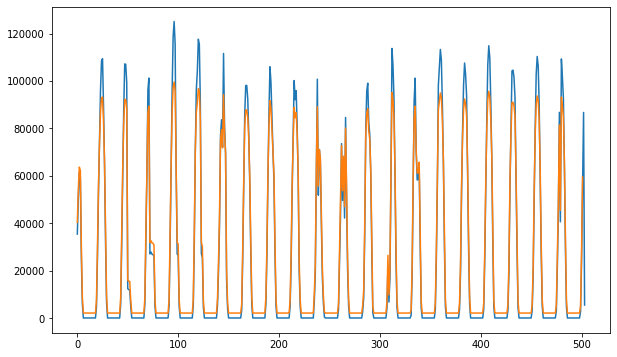

In [ ]:
X = scalerX.inverse_transform(p_train)
plt.figure(figsize=(10, 6))
plt.plot(X)
plt.plot(trainPredict)
plt.show()

# save predictions to CSV
df = pd.DataFrame({"year" : year[126:628], "month" : month[126:628], "day": day[126:628], "hour": hour[126:628], \
                   "solar_power":trainPredict.reshape(-1)})
df.to_csv("predictions3.csv", index=False)

In [ ]:
(trainX.shape[0], 1, trainX.shape[1])
print(trainH[4,0,0])

In [ ]:
# enhancing model with hours as input
trainXX = []
for i in range(trainX.shape[0]):
  a =[]
  a.append([trainX[i,0,0], trainH[i,0,0]])
  trainXX.append(a)

testXX = []
for i in range(testX.shape[0]):
  a =[]
  a.append([testX[i,0,0], testH[i,0,0]])
  testXX.append(a)

trainXX = np.array(trainXX)
testXX = np.array(testXX)

trainYY = np.reshape(trainY, (-1,1))
trainYY = np.reshape(trainYY, (trainYY.shape[0], 1, trainYY.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#trainH = np.reshape(trainH, (trainH.shape[0], 1, trainH.shape[1]))
#testH = np.reshape(testH, (testH.shape[0], 1, testH.shape[1]))
print(trainXX.shape)
model = Sequential()
model.add(LSTM(4, input_shape=(look_back,2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainXX, trainYY, epochs=100, batch_size=1, verbose=2)
model.save_weights("solar_model_enhanced.h5")
# last epoch MSE=0.0059 

# make predictions
trainPredict = model.predict(trainXX)
testPredict = model.predict(testXX)
# invert predictions
trainPredict = scalerX.inverse_transform(trainPredict)
trainY = scalerX.inverse_transform([trainY])
testPredict = scalerX.inverse_transform(testPredict)
testY = scalerX.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# results
#Train Score: 9929.02 RMSE
#Test Score: 11714.01 RMSE

X = scalerX.inverse_transform(p_train)
plt.figure(figsize=(10, 6))
plt.plot(X)
plt.plot(trainPredict)
plt.show()

# save predictions to CSV
df = pd.DataFrame({"year" : year[126:628], "month" : month[126:628], "day": day[126:628], "hour": hour[126:628], \
                   "solar_power":trainPredict.reshape(-1)})
df.to_csv("predictions3h.csv", index=False)

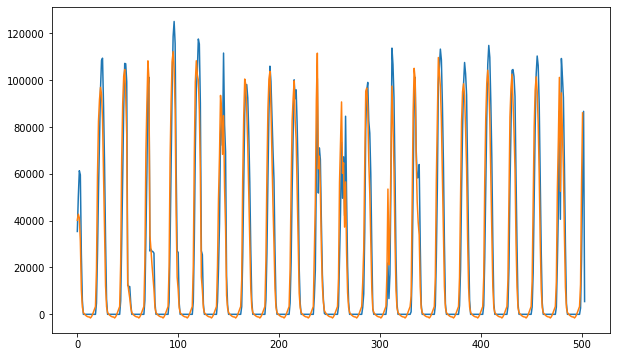

In [ ]:
X = scalerX.inverse_transform(p_train)
plt.figure(figsize=(10, 6))
plt.plot(X)
plt.plot(trainPredict)
plt.show()